<div align="center">

# 🌙 <a href="https://moonarc.streamlit.app/" target="_blank">MOONARC</a>  
## A Deep Learning Approach for Real-Time Lunar Phase Detection  

</div>


MoonArc presents a **modern solution** to an age-old fascination: the **moon**. Using **deep learning techniques**, this project provides **real-time predictions of lunar phases** from uploaded or captured moon images.  

### 🌌 Key Features:
- **Real-time Lunar Phase Detection**: Upload or capture an image, and the model identifies the moon phase instantly.  
- **User-Friendly for Everyone**: Designed for students, astronomers, and cultural enthusiasts.  
- **Lunar Calendar Integration**: View historical and future moon phases for deeper insights.  

🔭 **Explore the moon like never before!**  

---

### 📷 Lunar Phase Detection Preview  
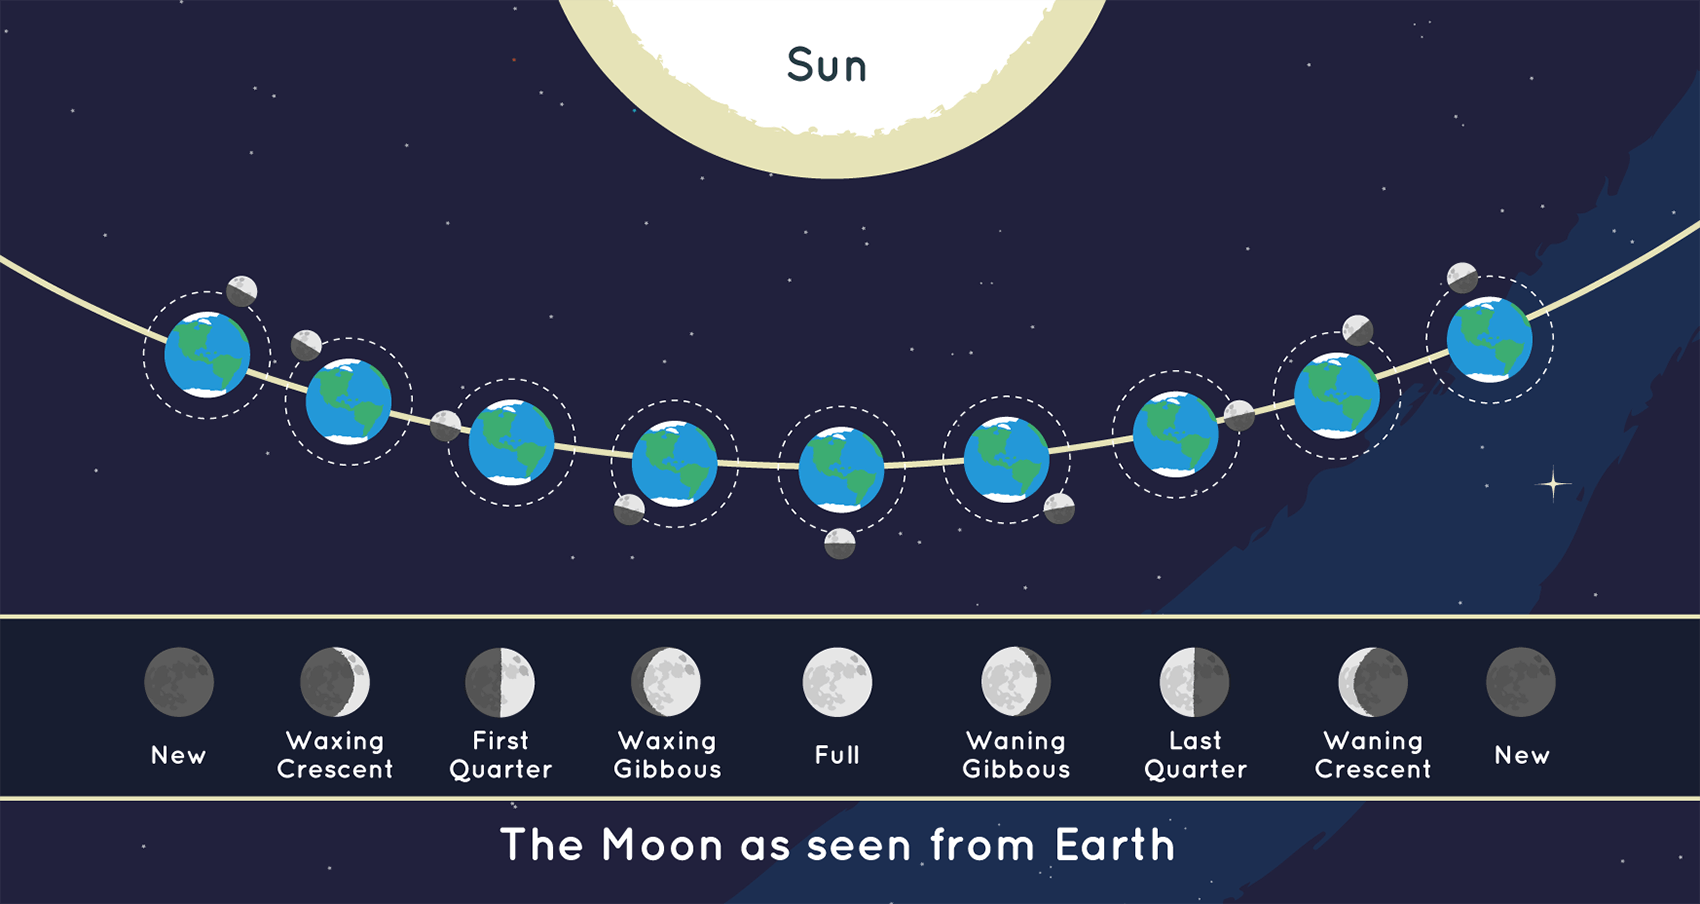  
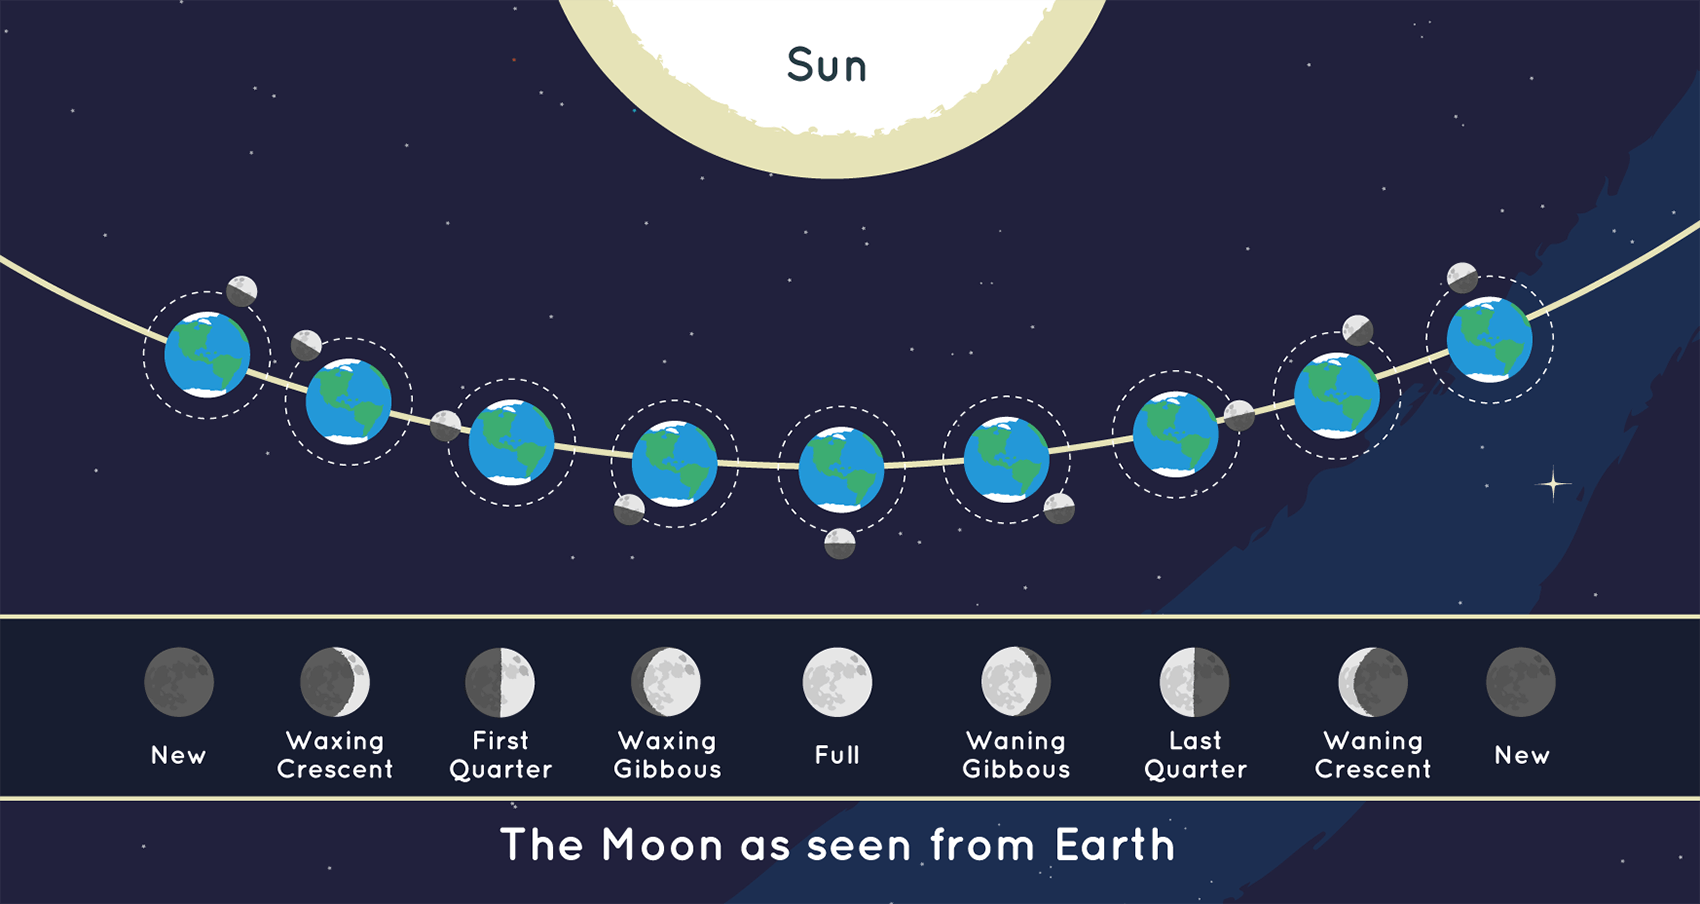

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/moons-images
/kaggle/input/moons-images/Original_Moon
/kaggle/input/moons-images/Original_Moon/waxing gibbous
/kaggle/input/moons-images/Original_Moon/waning gibbous
/kaggle/input/moons-images/Original_Moon/full moon
/kaggle/input/moons-images/Original_Moon/new moon
/kaggle/input/moons-images/Original_Moon/third quarter
/kaggle/input/moons-images/Original_Moon/waning crescent
/kaggle/input/moons-images/Original_Moon/no moon
/kaggle/input/moons-images/Original_Moon/waxing crescent
/kaggle/input/moons-images/Original_Moon/first quarter


# 📌Environment Setup and Library Imports
 This section suppresses warnings for cleaner outputs and imports essential libraries for image processing, visualization, and deep learning.


In [2]:
# Suppress all warning messages for cleaner output during execution
import warnings
warnings.filterwarnings("ignore")

# ### Core Libraries for Image Processing, Data Handling, and Visualization
import cv2  # OpenCV: Image processing operations (e.g., image filtering, transformation)
import os  # OS module: File path manipulation and directory operations
import numpy as np  # NumPy: Numerical operations on multi-dimensional arrays
import matplotlib.pyplot as plt  # Matplotlib: Data visualization and plotting utilities
import seaborn as sns  # Seaborn: Statistical data visualization built on top of Matplotlib

# ### Scikit-learn Utilities for Model Evaluation and Data Preprocessing
from sklearn.utils import class_weight  # Calculate class weights to handle imbalanced datasets
from sklearn.metrics import (
    classification_report,  # Generate a detailed classification performance report
    confusion_matrix,  # Compute and visualize confusion matrix
    precision_recall_curve,  # Calculate precision-recall pairs for different thresholds
    roc_curve,  # Generate ROC (Receiver Operating Characteristic) curve
    auc,  # Compute the Area Under the ROC Curve (AUC) score
    f1_score  # Evaluate model performance using the F1-score (harmonic mean of precision and recall)
)
from sklearn.preprocessing import label_binarize  # Convert categorical labels to binary form (for multi-class problems)

# ### TensorFlow and Keras Modules for Deep Learning Model Development
import tensorflow as tf  # TensorFlow: Core library for building and training deep learning models
from tensorflow.keras import layers, regularizers, Model  # Core Keras components for model building
from tensorflow.keras.models import Sequential  # Simplified API for layer stacking
from tensorflow.keras.applications import ResNet50  # Pre-trained ResNet50 model for transfer learning
from tensorflow.keras.applications.resnet import preprocess_input  # Input preprocessing for ResNet models
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Utilities for image loading and conversion

# ### Hyperparameter Tuning with Keras Tuner
import keras_tuner as kt  # Keras Tuner: Framework for automated hyperparameter tuning


# 📌 Moon Detection, Cropping, and Enhancement Pipeline
 This function detects the moon in an image, crops the detected region, enhances the cropped portion using contrast-limited adaptive histogram equalization (CLAHE), and saves the processed output.
 
 If the image is labeled as 'no moon', it is saved without further processing. The function ensures robust handling of cases where no moon is detected or when cropping is invalid.


In [3]:
def detect_and_crop_moon(image_path, output_folder, is_no_moon=False):
    """
    Detect and crop the moon from an image, enhance the cropped region, and save the result.

    If the 'is_no_moon' flag is True, the original image is saved directly without processing.

    Args:
        image_path (str): The file path of the input image.
        output_folder (str): The directory where the processed image will be saved.
        is_no_moon (bool): Flag indicating if the image should bypass moon detection and be saved as is.

    Returns:
        bool: True if the image was processed and saved successfully, False otherwise.
    """
    # Read the image from the specified path using OpenCV.
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return False

    # If flagged as 'no moon', save the original image without further processing.
    if is_no_moon:
        output_path = os.path.join(output_folder, os.path.basename(image_path))
        cv2.imwrite(output_path, image)
        return True

    # Convert the image to grayscale to facilitate moon detection.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise and smoothen the image for better contour detection.
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use adaptive thresholding to convert the image into a binary format for contour extraction.
    thresh = cv2.adaptiveThreshold(
        blurred,
        255,  # Maximum intensity value for thresholded pixels.
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Adaptive method: Gaussian-weighted mean.
        cv2.THRESH_BINARY_INV,  # Invert the threshold to highlight bright objects (e.g., the moon).
        11,  # Block size for local neighborhood consideration.
        2  # Constant subtracted from the mean to fine-tune thresholding.
    )

    # Find external contours in the binary image.
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Identify the largest contour, assuming it represents the moon.
        largest_contour = max(contours, key=cv2.contourArea)

        # Compute the minimum enclosing circle for the detected moon.
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Define cropping boundaries while ensuring they remain within image dimensions.
        y_min = max(center[1] - radius, 0)
        y_max = min(center[1] + radius, image.shape[0])
        x_min = max(center[0] - radius, 0)
        x_max = min(center[0] + radius, image.shape[1])
        cropped = image[y_min:y_max, x_min:x_max]

        # Ensure the cropped region is valid and contains image data.
        if cropped.size == 0:
            print(f"Invalid cropping for {image_path}")
            return False

        # Enhance the cropped moon image using CLAHE for better contrast and visibility.
        lab = cv2.cvtColor(cropped, cv2.COLOR_BGR2LAB)  # Convert to LAB color space.
        l_channel, a_channel, b_channel = cv2.split(lab)  # Split into L (lightness), A, and B channels.

        # Apply CLAHE to the lightness channel to improve contrast in the cropped region.
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_l = clahe.apply(l_channel)

        # Merge the enhanced L channel with the original A and B channels.
        enhanced_lab = cv2.merge((clahe_l, a_channel, b_channel))

        # Convert the enhanced image back to BGR color space.
        enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        # Save the enhanced, cropped image to the specified output directory.
        output_path = os.path.join(output_folder, os.path.basename(image_path))
        cv2.imwrite(output_path, enhanced)

        return True
    else:
        # Log a message if no moon is detected in the image.
        print(f"No moon detected in {image_path}")
        return False

# 📌 Moon Phase Image Dataset Processing
This cell processes a dataset of moon images categorized by moon phases. The function detects and crops the moon from each image using a detection pipeline. Images from 'new moon' or 'no moon' phases are directly saved without moon detection. The processed images are saved in a separate output directory.


In [4]:
def process_dataset(input_folder, output_folder):
    """
    Process an entire dataset by detecting and cropping the moon from each image.

    The dataset is organized in subfolders representing different moon phases. For each image,
    this function applies the detection and cropping pipeline, and saves the processed image.

    Args:
        input_folder (str): Directory containing the original images, categorized by moon phase.
        output_folder (str): Directory where processed images will be stored.
    """
    # Iterate through each subfolder (representing a moon phase) in the input directory.
    for phase_folder in os.listdir(input_folder):
        phase_path = os.path.join(input_folder, phase_folder)

        # Check if the current path is a directory (ignore files).
        if os.path.isdir(phase_path):
            # Create a corresponding output folder for the current moon phase.
            output_phase_path = os.path.join(output_folder, phase_folder)
            os.makedirs(output_phase_path, exist_ok=True)

            # Process each image in the current moon phase folder.
            for image_name in os.listdir(phase_path):
                image_path = os.path.join(phase_path, image_name)

                # Determine whether the current phase should be treated as 'no moon'.
                is_no_moon = phase_folder.lower() in ['new moon', 'no moon']

                # Attempt to process and crop the moon; log the result if processing fails.
                if detect_and_crop_moon(image_path, output_phase_path, is_no_moon):
                    pass  # Image processed successfully, no further action needed.
                else:
                    print(f"Failed to process {image_path}")

    print("Dataset process done!")

# Define the input and output directories for the dataset.
input_folder = '/kaggle/input/moons-images/Original_Moon'  # Path to original moon images.
output_folder = '/kaggle/working/Preprocess_Moon'  # Path to save processed moon images.

# Process the dataset: detect, crop, and enhance moon images, then save the processed images.
process_dataset(input_folder, output_folder)


Dataset process done!


# 📌 Class Weight Calculation for Imbalanced Moon Phase Dataset
 This cell defines a function to compute class weights based on the number of images in each moon phase category. Class weights are useful in addressing dataset imbalance during model training, ensuring that underrepresented moon phases are adequately learned by the model.


In [5]:
# Function to calculate class weights for the dataset.
def calculate_class_weights(data_dir, class_names):
    """
    Calculate class weights based on the number of images in each class folder.
    
    This is useful for handling imbalanced datasets during model training.
    
    Args:
        data_dir (str): Directory containing class subfolders.
        class_names (list): List of class names corresponding to the subfolders.
    
    Returns:
        dict: Dictionary mapping class indices to their computed weights.
    """
    all_labels = []  # List to accumulate labels for each image.
    
    # Iterate over each class, adding its label (index) for every image in the class folder.
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)  # Path to the class folder.
        all_labels.extend([label_idx] * len(os.listdir(class_dir)))  # Extend label list with the class index.
    
    # Compute balanced class weights using sklearn's compute_class_weight.
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
    
    # Return a dictionary mapping class indices to their weights.
    return dict(enumerate(class_weights))

# 📌 Image Counting and Dataset Preparation
 This section counts the number of images in each moon phase folder of the preprocessed dataset. It also prepares the dataset for training and validation by using an 80-20 split, resizing images, and calculating class weights to address dataset imbalance.


In [6]:
# Count the number of images in each folder of the preprocessed dataset.
count = 0  # Initialize total image counter.
dirs = os.listdir('/kaggle/working/Preprocess_Moon/')  # List all subdirectories in the preprocessed dataset.

# Iterate through each folder and count the images it contains.
for dir in dirs:
    files = list(os.listdir(os.path.join('/kaggle/working/Preprocess_Moon/', dir)))  # Get list of images in the current folder.
    print(f"{dir} Folder has {len(files)} Moon")  # Display the count of images in the folder.
    count += len(files)  # Add to the total image count.

# Print the total number of images in the preprocessed dataset.
print(f'Preprocess_Moon Folder has {count} Images')

third quarter Folder has 111 Moon
first quarter Folder has 104 Moon
waxing crescent Folder has 150 Moon
new moon Folder has 22 Moon
waxing gibbous Folder has 131 Moon
full moon Folder has 209 Moon
waning gibbous Folder has 99 Moon
waning crescent Folder has 124 Moon
no moon Folder has 360 Moon
Preprocess_Moon Folder has 1310 Images


In [7]:
# Define the base directory for the preprocessed dataset and set image and batch parameters.
base_dir = '/kaggle/working/Preprocess_Moon/'
img_size = 224  # Target image size (height and width).
batch = 16    # Batch size for loading images.

# Load the training dataset using a 80-20 split from the preprocessed images.
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,                   # Seed for shuffling and transformations.
    validation_split=0.2,       # 20% of the data will be used for validation.
    subset='training',          # Specify this subset for training data.
    batch_size=batch,
    image_size=(img_size, img_size)  # Resize images to the specified dimensions.
)

# Load the validation dataset using the same split parameters.
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',        # Specify this subset for validation data.
    batch_size=batch,
    image_size=(img_size, img_size)
)

Found 1310 files belonging to 9 classes.
Using 1048 files for training.
Found 1310 files belonging to 9 classes.
Using 262 files for validation.


In [8]:
# Retrieve the list of class names (labels) based on subfolder names.
class_names = train_ds.class_names
print("Class Names:", class_names)

# Calculate class weights to handle any class imbalance in the dataset.
class_weights = calculate_class_weights(base_dir, class_names)
print("Class Weights:", class_weights)

Class Names: ['first quarter', 'full moon', 'new moon', 'no moon', 'third quarter', 'waning crescent', 'waning gibbous', 'waxing crescent', 'waxing gibbous']
Class Weights: {0: 1.3995726495726495, 1: 0.6964380648591175, 2: 6.616161616161616, 3: 0.404320987654321, 4: 1.3113113113113113, 5: 1.1738351254480286, 6: 1.4702581369248036, 7: 0.9703703703703703, 8: 1.1111111111111112}


# 📌 Data Augmentation and Dataset Optimization
### 1. **Visualize a Sample Batch Before Data Augmentation**

This section displays a batch of images from the training dataset before applying any augmentation. Visualizing raw images helps to understand the dataset's structure and quality.


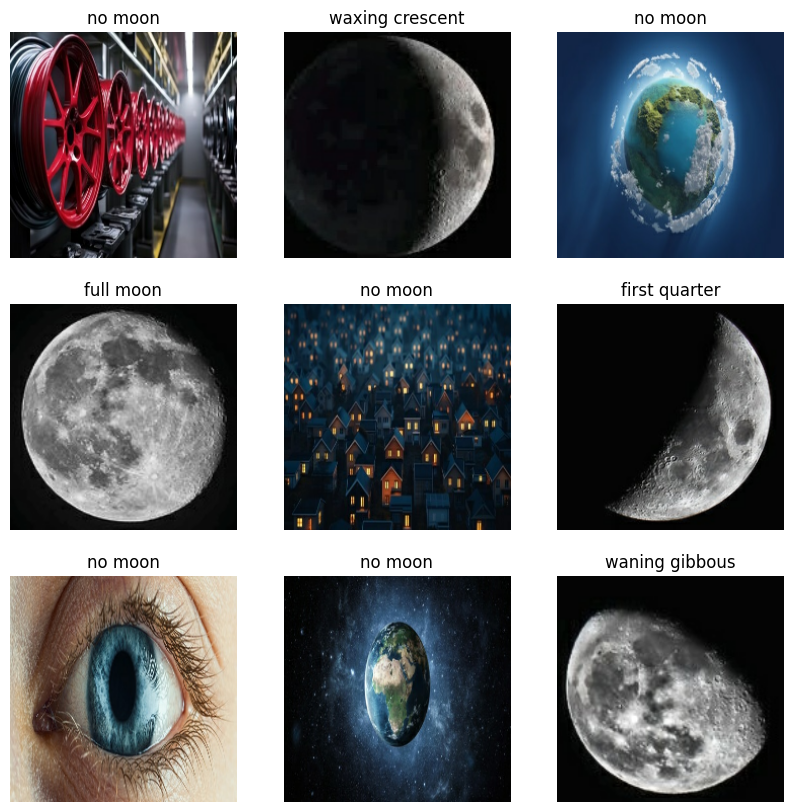

In [9]:
# Display a grid of 9 sample images from the training dataset (before augmentation).
i = 0
plt.figure(figsize=(10,10))

# Take one batch of images and labels from the training dataset.
for images, labels in train_ds.take(9):
    for i in range(9):
        plt.subplot(3,3, i+1)              # Create a 3x3 grid for displaying images.
        plt.imshow(images[i].numpy().astype('uint8'))  # Convert image to uint8 format for visualization.
        plt.title(class_names[labels[i]])  # Set the title to the corresponding class name.
        plt.axis('off')                    # Hide axes for a cleaner display.

### 2. **Define Enhanced Data Augmentation Layers**

This section defines a sequential data augmentation pipeline to improve model generalization and prevent overfitting. Selected augmentations include brightness adjustment, contrast variation, and Gaussian noise.

In [10]:
# Create a Sequential model to apply image augmentation transformations.
data_augmentation = Sequential([
    layers.RandomBrightness(factor=0.2),   # Randomly adjust brightness with a factor range of ±20%.
    layers.RandomContrast(0.3),            # Randomly adjust contrast within a range of ±30%.
    layers.GaussianNoise(0.02),            # Add Gaussian noise with a standard deviation of 0.02.
])

### 3. **Optimize the Dataset Pipeline**

To improve training efficiency, the dataset is cached, shuffled, and prefetched using TensorFlow's `AUTOTUNE`. This optimization speeds up data loading and enhances training performance.


In [11]:
# Optimize dataset loading for better performance.
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, and prefetch the training dataset.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for efficient loading.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 4. **Visualize a Sample Batch After Data Augmentation**

This section visualizes augmented images to verify that the transformations are applied correctly. 

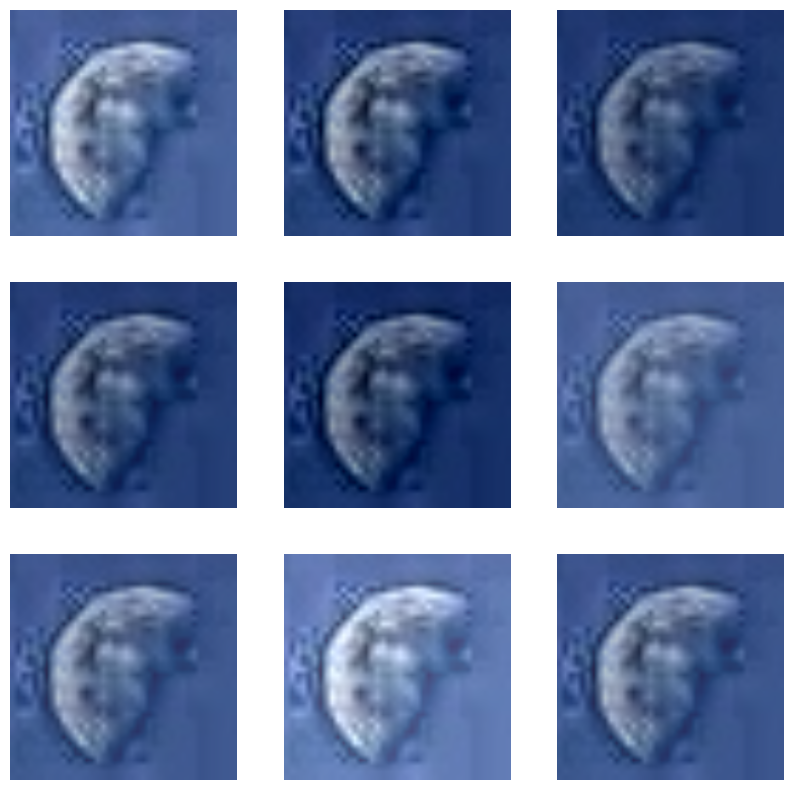

In [12]:
# Display a grid of 9 augmented images.
i = 0
plt.figure(figsize=(10,10))

# Apply augmentation and visualize the transformed images.
for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)   # Apply augmentation to the batch.
        plt.subplot(3,3, i+1)               # Create a 3x3 grid for display.
        plt.imshow(images[0].numpy().astype('uint8'))  # Display the augmented image.
        plt.axis('off')                     # Hide axes for cleaner visualization.

# 📌 Hyperparameter Tuning with ResNet50
### 1. **Custom Preprocessing Function**

This function applies EfficientNet's `preprocess_input` transformation to the input image. It is wrapped in a Lambda layer to ensure compatibility with the TensorFlow model.

In [13]:
# Custom preprocessing function for the Lambda layer in the EfficientNet model.
def resnet_preprocess(img):
    """
    Preprocess the input image using EfficientNet's preprocess_input function.

    Args:
        img (np.array or Tensor): Input image array to be preprocessed.

    Returns:
        Preprocessed image ready for EfficientNet.
    """
    return preprocess_input(img)

### 2. **Build Model Function with Tunable Hyperparameters**

This function builds a ResNet50-based model with hyperparameters for fine-tuning, including:
- Number of trainable layers.
- Dropout rates for regularization.
- Dense layer size and L2 regularization.
- Learning rate selection.

In [14]:
# Function to build a ResNet50 model with tunable hyperparameters for optimization.
def build_model(hp):
    # Input layer with specified image size.
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Apply data augmentation to input images.
    x = data_augmentation(inputs)

    # Preprocess images using the custom preprocessing function.
    x = layers.Lambda(resnet_preprocess)(x)

    # Load the ResNet50 base model with ImageNet weights (excluding the top layers).
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)

    # Make some layers trainable based on a tunable hyperparameter.
    num_unfrozen = hp.Int('num_unfrozen', min_value=10, max_value=160, step=30)
    for layer in base_model.layers[:-num_unfrozen]:
        layer.trainable = False
    for layer in base_model.layers[-num_unfrozen:]:
        layer.trainable = True

    # Add a global average pooling layer and batch normalization.
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)

    # Apply the first dropout layer with a tunable rate for regularization.
    dropout_rate_1 = hp.Float('dropout1', 0.3, 0.7, step=0.1)
    x = layers.Dropout(dropout_rate_1)(x)

    # Add a dense layer with tunable units and L2 regularization.
    dense_units = hp.Int('dense_units', 128, 512, step=128)
    l2_reg = hp.Float('l2_reg', 1e-5, 1e-3, sampling='log')
    x = layers.Dense(dense_units, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)

    # Apply a second dropout layer with a tunable rate.
    dropout_rate_2 = hp.Float('dropout2', 0.2, 0.6, step=0.1)
    x = layers.Dropout(dropout_rate_2)(x)

    # Output layer with softmax activation for multi-class classification.
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    # Compile the model with a tunable learning rate.
    lr = hp.Choice('learning_rate', values=[1e-4, 5e-5, 1e-5])

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### 3. **Initialize and Configure the Hyperparameter Tuner**

This section uses `kt.BayesianOptimization` for hyperparameter search. The search will try up to 25 different model configurations.


In [15]:
# Initialize Bayesian Optimization tuner for hyperparameter search.
tuner = kt.BayesianOptimization(
    build_model,                  # Model-building function.
    objective='val_accuracy',      # Optimize for validation accuracy.
    max_trials=25,                 # Maximum search trials.
    executions_per_trial=1,        # Single execution per trial.
    directory='hyperparameter_tuning',
    project_name='resnet50_overfit_reduction'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 4. **Define Model Callbacks**

Key callbacks include:
- **ReduceLROnPlateau**: Reduces learning rate when the validation loss plateaus.
- **EarlyStopping**: Stops training if validation loss doesn't improve after 10 epochs.


In [16]:
# Callback to reduce learning rate when validation loss plateaus.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss.
    factor=0.5,            # Reduce learning rate by a factor of 0.5.
    patience=3,            # Wait for 3 epochs before reducing.
    min_lr=1e-6            # Minimum learning rate.
)

# Callback to stop training early if no improvement is seen.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor validation loss.
    patience=10,                 # Wait for 10 epochs before stopping.
    restore_best_weights=True    # Restore the best weights after stopping.
)

### 5. **Execute Hyperparameter Search**

Run the hyperparameter search over the training and validation datasets with the defined callbacks.

In [17]:
tuner.search(
    train_ds,
    epochs=100,               # Maximum epochs for tuning.
    validation_data=val_ds,   # Validation dataset.
    class_weight=class_weights,  # Handle class imbalance.
    callbacks=[reduce_lr, early_stop]
)

Trial 25 Complete [00h 01m 39s]
val_accuracy: 0.927480936050415

Best val_accuracy So Far: 0.9503816962242126
Total elapsed time: 01h 04m 26s


### 6. **Build and Train the Final Model**

After finding the optimal hyperparameters, this section trains the final model using the best configuration.


In [18]:
# Retrieve the best hyperparameters from the tuning process.
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
Optimal hyperparameters:
- Number of trainable layers: {best_hps.get('num_unfrozen')}
- First dropout rate: {best_hps.get('dropout1')}
- Second dropout rate: {best_hps.get('dropout2')}
- Dense units: {best_hps.get('dense_units')}
- L2 regularization: {best_hps.get('l2_reg')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Build the final model with the best hyperparameters.
final_model = tuner.hypermodel.build(best_hps)

# Train the final model on the full dataset.
final_history = final_model.fit(
    train_ds,
    epochs=200,  # Increased epochs for comprehensive training.
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[
        reduce_lr,
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            save_best_only=True,
            monitor='val_accuracy'
        )
    ]
)

# Evaluate the final model on the validation dataset.
test_loss, test_acc = final_model.evaluate(val_ds)
print(f"\nFinal Test Accuracy: {test_acc:.2%}")


Optimal hyperparameters:
- Number of trainable layers: 10
- First dropout rate: 0.6000000000000001
- Second dropout rate: 0.5
- Dense units: 256
- L2 regularization: 0.000388359870912422
- Learning rate: 5e-05

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.2152 - loss: 3.9524 - val_accuracy: 0.5878 - val_loss: 1.4496 - learning_rate: 5.0000e-05
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3626 - loss: 2.5621 - val_accuracy: 0.7595 - val_loss: 0.9823 - learning_rate: 5.0000e-05
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5245 - loss: 1.8895 - val_accuracy: 0.8092 - val_loss: 0.8253 - learning_rate: 5.0000e-05
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5766 - loss: 1.5347 - val_accuracy: 0.8588 - val_loss: 0.7032 - learning_rate: 5.0000e-05
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6838 - loss: 1.2725 - val_accuracy: 0.8740 - val_loss: 0.6295 - learning_rate: 5.0000e-05
Epoch 

In [19]:
# Display the model's architecture.
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 224, 224, 3)    │              0 │ sequential[26][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 34,115,997 (130.14 MB)

 Trainable params: 4,996,617 (19.06 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

 Optimizer params: 9,993,236 (38.12 MB)

# 📌 Model Evaluation and Moon Phase Prediction with Threshold
This section evaluates the trained ResNet50 model on both training and validation datasets, providing accuracy metrics. Additionally, it defines a custom prediction function that classifies moon phases and handles 'no-moon' cases based on a confidence threshold.



In [20]:
# -------------------------------
# Evaluate the trained model on both training and validation datasets.
# -------------------------------

# Evaluate and store performance metrics for training and validation datasets.
train_loss, train_accuracy = final_model.evaluate(train_ds)  # Training dataset evaluation.
val_loss, val_accuracy = final_model.evaluate(val_ds)        # Validation dataset evaluation.

# Display the accuracy results for training and validation datasets.
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9875 - loss: 0.2236
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9485 - loss: 0.3918
Training Accuracy: 0.9837786555290222
Validation Accuracy: 0.9236640930175781


#### 📈 Why Use a Prediction Threshold?
Handles ambiguous cases where the model's confidence is low.

Enhances real-world applicability by recognizing 'no-moon' cases effectively.


In [21]:
# -------------------------------
# Function to make predictions with a threshold to detect 'no-moon' cases.
# -------------------------------

def predict_with_threshold(image, model, threshold=0.5):
    """
    Predict the moon phase or 'no-moon' if the confidence is below the threshold.

    Args:
        image (Tensor): Preprocessed image tensor ready for prediction.
        model (tf.keras.Model): Trained deep learning model.
        threshold (float): Minimum confidence threshold to classify an image as a moon phase.

    Returns:
        str: Predicted moon phase label or 'no-moon' if confidence is too low.
    """
    # Perform prediction on the input image (expand dimensions to match model input).
    predictions = model.predict(tf.expand_dims(image, axis=0))

    # Identify the highest probability from the model output.
    max_prob = np.max(predictions)

    # If the highest probability is below the threshold, classify as 'no-moon'.
    if max_prob < threshold:
        return "no-moon"
    else:
        # Get the class index corresponding to the highest probability.
        predicted_class = np.argmax(predictions)
        return class_names[predicted_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Label: waxing crescent


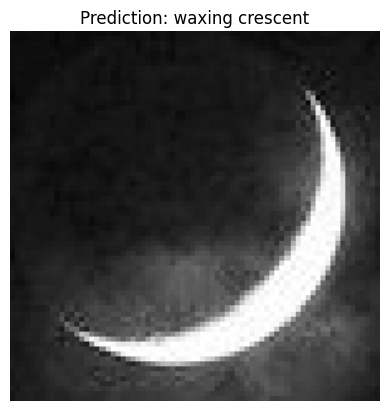

In [22]:
# -------------------------------
# Example Usage: Load an image and perform a prediction.
# -------------------------------

# Specify the path to the test image.
image_path = '/kaggle/working/Preprocess_Moon/waxing crescent/1219.jpeg'

# Load and resize the image to match the model's input dimensions.
image = load_img(image_path, target_size=(img_size, img_size))

# Convert the image to a NumPy array.
image_array = img_to_array(image)

# Apply the same preprocessing as used during training.
image_array = preprocess_input(image_array)

# Predict the moon phase using the model and threshold-based classification.
predicted_label = predict_with_threshold(image_array, final_model, threshold=0.5)

# Display the predicted moon phase or 'no-moon' label.
print("Predicted Label:", predicted_label)

# Visualize the test image with the predicted label as the title.
plt.imshow(image)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()

### 📊  Model Performance Visualization

 This section visualizes the training history, including accuracy and loss trends, to assess the model's learning behavior.

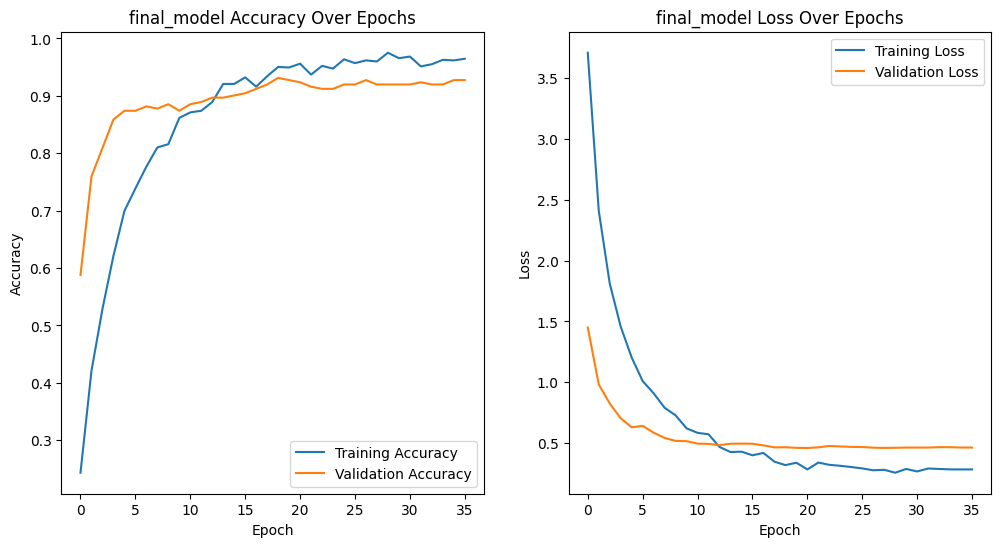

In [23]:
# Plot training history to visualize model performance.

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('final_model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('final_model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 📊 Classification Report

 This section computes and displays the classification report, which provides key metrics (precision, recall, and F1-score) for each class.

In [24]:
# Function to print the classification report for model evaluation.

def print_classification_report(y_true, y_pred):
    """
    Generate and display a classification report.

    Args:
        y_true (list or np.array): True class labels.
        y_pred (list or np.array): Predicted class labels.

    Returns:
        None: Prints the classification report.
    """
    report = classification_report(y_true, y_pred)  # Compute classification report
    print("Classification Report:")
    print(report)


# Extract true labels from the validation dataset.

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())  # Store true labels

y_true = np.array(y_true)  # Convert list to NumPy array

# Generate model predictions on the validation dataset.

y_pred = []
for images, labels in val_ds:
    predictions = final_model.predict(images)  # Predict class probabilities
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class labels

# Print classification report.
print_classification_report(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       1.00      1.00      1.00        33
           2       0.71      1.00      0.83         5
           3       0.97      0.97      0.97        89
           4       0.89      0.89      0.89        18
          

### 📊  Confusion Matrix

 This section visualizes the confusion matrix, providing detailed insights into model errors and correctly classified instances.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


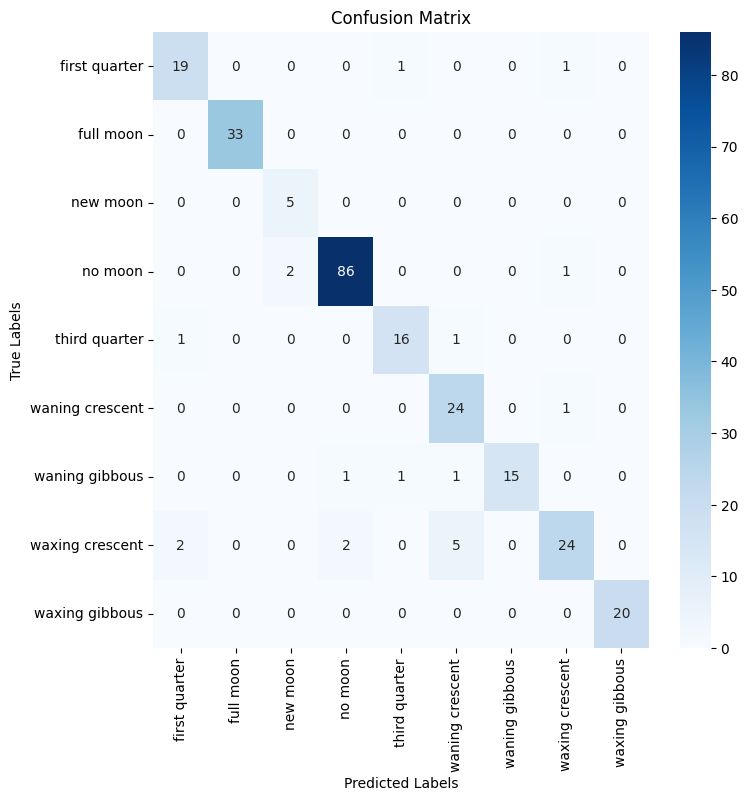

In [25]:
# Function to plot the confusion matrix for detailed performance analysis.

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Generate and display a confusion matrix to evaluate model performance.

    Args:
        y_true (list or np.array): True class labels.
        y_pred (list or np.array): Predicted class labels.
        classes (list): Class names corresponding to the labels.

    Returns:
        None: Displays the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


# Extract true labels again for confusion matrix computation.

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

# Generate predicted labels again for confusion matrix.

y_pred = []
for images, labels in val_ds:
    predictions = final_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Plot and display the confusion matrix.
plot_confusion_matrix(y_true, y_pred, class_names)

### 📊  Precision-Recall Curve

 This section plots Precision-Recall curves for each class, using the One-vs-Rest (OvR) strategy to visualize class-wise performance.

 This visualization evaluates the trade-off between precision and recall for each class.

 The One-vs-Rest (OvR) approach is used to handle multiclass classification.

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step


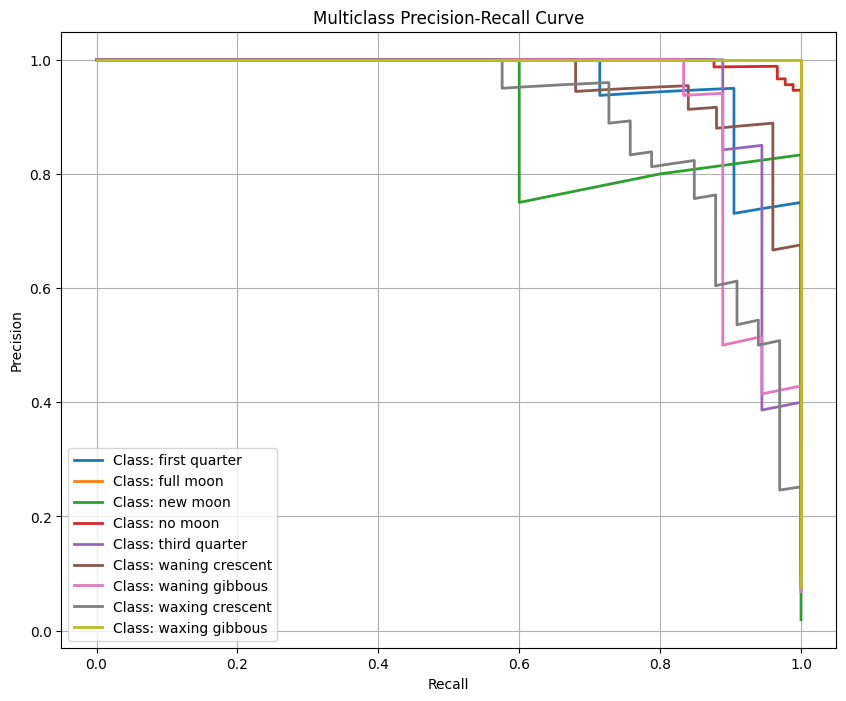

In [26]:
def plot_multiclass_precision_recall_curve(y_true, y_pred_proba, class_names):
    """
    Generate and display Precision-Recall curves for each class (One-vs-Rest approach).

    Args:
        y_true (list or np.array): True class labels.
        y_pred_proba (np.array): Predicted probabilities for each class (shape: [n_samples, n_classes]).
        class_names (list): Class names corresponding to the labels.

    Returns:
        None: Displays Precision-Recall curves for each class.
    """
    # Binarize the true labels for multiclass handling
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_bin.shape[1]

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class: {class_names[i]}')

    # Plot formatting
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multiclass Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Get model predictions for validation set
y_prob = final_model.predict(val_ds)  # Predicted probabilities for each class

# Extract true labels from the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())  # Store true labels

y_true = np.array(y_true)  # Convert list to NumPy array

# Plot Precision-Recall Curve for multiclass classification
plot_multiclass_precision_recall_curve(y_true, y_prob, class_names)

### 📊  ROC Curve & AUC Score

 This section plots ROC curves with AUC scores to measure the model's ability to distinguish between classes.
 
 The ROC (Receiver Operating Characteristic) curve visualizes the model's performance at various classification thresholds.

 The Area Under the Curve (AUC) measures the model’s ability to distinguish between classes. A higher AUC indicates better performance.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


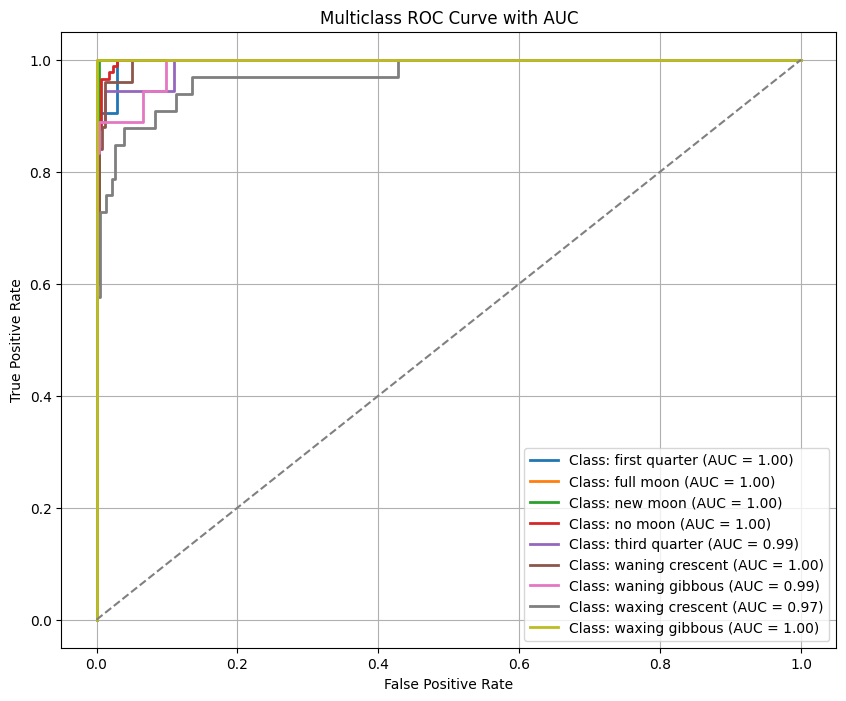

In [27]:
def plot_multiclass_roc_curve(y_true, y_pred_proba, class_names):
    """
    Generate and display ROC curves with AUC scores for each class (One-vs-Rest approach).

    Args:
        y_true (list or np.array): True class labels.
        y_pred_proba (np.array): Predicted probabilities for each class (shape: [n_samples, n_classes]).
        class_names (list): Class names corresponding to the labels.

    Returns:
        None: Displays ROC curves for each class.
    """
    # Binarize the true labels for multiclass ROC
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_bin.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC Curve for each class
        plt.plot(fpr, tpr, lw=2, label=f'Class: {class_names[i]} (AUC = {roc_auc:.2f})')

    # Plot the reference line (no-skill classifier)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve with AUC')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Assuming `model` is your trained model, and `val_ds` is your validation dataset
y_prob = final_model.predict(val_ds)  # Predicted probabilities for each class

# Extract true labels from the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())  # Store true labels

y_true = np.array(y_true)  # Convert list to NumPy array

# List of class names corresponding to your lunar phases
#class_names = ["New Moon", "Waxing Crescent", "First Quarter", "Waxing Gibbous", "Full Moon", "Waning Gibbous", "Last Quarter", "Waning Crescent"]

# Plot the ROC Curve
plot_multiclass_roc_curve(y_true, y_prob, class_names)


### 📊 Per-Class Precision, Recall, and F1-Score Visualization

This section generates a bar chart to visualize the **precision**, **recall**, and **F1-score** for each class. This detailed breakdown helps in understanding how well the model performs across different categories.


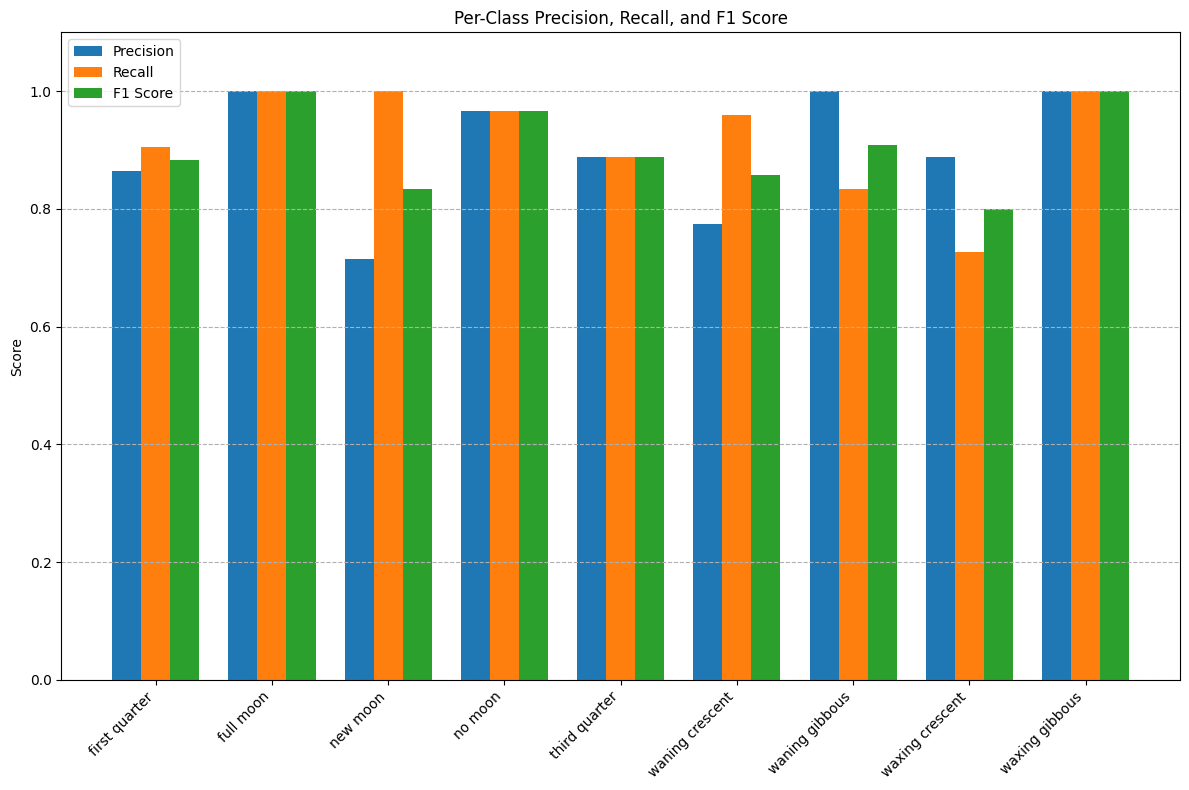

In [28]:
def plot_per_class_metrics(y_true, y_pred, class_names):
    """
    Generate and display a bar chart of per-class precision, recall, and F1-score.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    
    classes = list(report.keys())[:-3]
    precision = [report[cls]['precision'] for cls in classes]
    recall = [report[cls]['recall'] for cls in classes]
    f1 = [report[cls]['f1-score'] for cls in classes]

    # Create numerical indices for classes
    x = np.arange(len(class_names))
    width = 0.25  # Adjusted width for better spacing
    
    plt.figure(figsize=(12, 8))
    
    # Plot bars with proper positioning
    plt.bar(x - width, precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar(x + width, f1, width=width, label='F1 Score')

    # Set class names as tick labels
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)  # Set consistent y-axis limits
    plt.title('Per-Class Precision, Recall, and F1 Score')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# Generate predictions and true labels correctly
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())  # Convert tensor to numpy array
    predictions = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

# Ensure class_names matches the order used in model training
plot_per_class_metrics(y_true, y_pred, class_names)